## Load Packages and Import Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from random import sample
from random import seed
from datetime import datetime
from dateutil.relativedelta import relativedelta
import plotly.express as px
import calendar

In [2]:
SEED = 456
TEST = 0.2
PATH = "Data/"

In [3]:
nyc_restaurants = pd.read_csv(PATH + "DOHMH_New_York_City_Restaurant_Inspection_Results.csv")
nyc_restaurants = nyc_restaurants.iloc[:, 0:20]
nyc_restaurants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198622 entries, 0 to 198621
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   CAMIS                  198622 non-null  int64  
 1   DBA                    196857 non-null  object 
 2   BORO                   198622 non-null  object 
 3   BUILDING               198255 non-null  object 
 4   STREET                 198595 non-null  object 
 5   ZIPCODE                195922 non-null  float64
 6   PHONE                  198612 non-null  object 
 7   CUISINE DESCRIPTION    194269 non-null  object 
 8   INSPECTION DATE        198622 non-null  object 
 9   ACTION                 194269 non-null  object 
 10  VIOLATION CODE         193179 non-null  object 
 11  VIOLATION DESCRIPTION  193179 non-null  object 
 12  CRITICAL FLAG          198622 non-null  object 
 13  SCORE                  187609 non-null  float64
 14  GRADE                  96904 non-nul

In [4]:
["{}: {}".format(column, nyc_restaurants[column].isna().sum()) for column in nyc_restaurants.columns]

['CAMIS: 0',
 'DBA: 1765',
 'BORO: 0',
 'BUILDING: 367',
 'STREET: 27',
 'ZIPCODE: 2700',
 'PHONE: 10',
 'CUISINE DESCRIPTION: 4353',
 'INSPECTION DATE: 0',
 'ACTION: 4353',
 'VIOLATION CODE: 5443',
 'VIOLATION DESCRIPTION: 5443',
 'CRITICAL FLAG: 0',
 'SCORE: 11013',
 'GRADE: 101718',
 'GRADE DATE: 109101',
 'RECORD DATE: 0',
 'INSPECTION TYPE: 4353',
 'Latitude: 303',
 'Longitude: 303']

## Unscored Data

In [5]:
scoreless_idx = np.where(nyc_restaurants.SCORE.isna() == True)
scoreless = nyc_restaurants.iloc[scoreless_idx]
["{}: {}".format(column, nyc_restaurants[column].isna().sum() - scoreless[column].isna().sum()) for column in scoreless.columns]
#["{}: {}".format(column, nyc_restaurants[column].isna().sum()) for column in nyc_restaurants.columns]

# most unscored restaurants correlate with missing name, cuisine info, action, inspection type,
# violation code and description above (missing other data)

['CAMIS: 0',
 'DBA: 0',
 'BORO: 0',
 'BUILDING: 317',
 'STREET: 0',
 'ZIPCODE: 2529',
 'PHONE: 9',
 'CUISINE DESCRIPTION: 0',
 'INSPECTION DATE: 0',
 'ACTION: 0',
 'VIOLATION CODE: 618',
 'VIOLATION DESCRIPTION: 618',
 'CRITICAL FLAG: 0',
 'SCORE: 0',
 'GRADE: 90723',
 'GRADE DATE: 98091',
 'RECORD DATE: 0',
 'INSPECTION TYPE: 0',
 'Latitude: 237',
 'Longitude: 237']

Median: 18.0
Mean: 22.1


3rd Quartile: 30.0



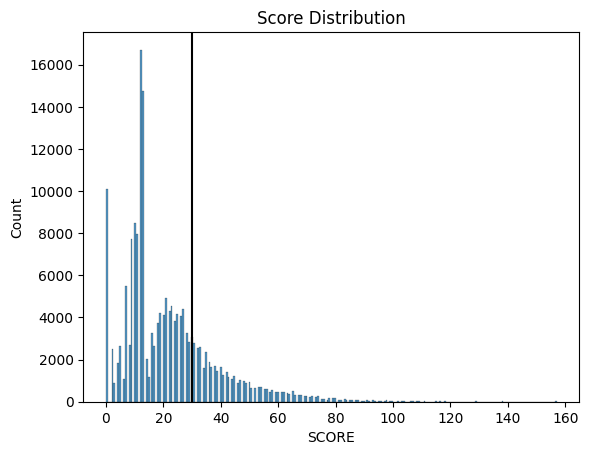

In [6]:
print("Median: {}".format(np.median(nyc_restaurants.SCORE.dropna())))
print("Mean: {:.1f}".format(np.mean(nyc_restaurants.SCORE)))
score_3rdq = nyc_restaurants.sort_values(by = "SCORE", ascending = True).\
iloc[np.ceil(.75*(len(nyc_restaurants.SCORE.dropna())+1)).astype('int32')].SCORE

print("3rd Quartile: {}".format(score_3rdq))
print("")

scoreplot = sns.histplot(nyc_restaurants.SCORE)
scoreplot.axvline(score_3rdq, color = "black")
plt.title("Score Distribution")
plt.show()

## Data Tidying (Unaffected by Splitting)

In [7]:
# Drop missing scores (cannot reasonably impute)

nyc_restaurants = nyc_restaurants.dropna(subset = "SCORE").reset_index(drop = True)
nyc_restaurants.shape

(187609, 20)

In [8]:
#nyc_restaurants["INSPECTION TYPE"].value_counts()

# Pre-permit (operation vs non-op...)
# Cycle
# initial
# Reopening
# Compliance
# Re-inspection

# Inspection Type: Pre-permit and Cycle (Inter-Agency Task Force - 375)

# Inspection Purpose: Initial, Re-inspection (if initial 14+ points), 
# (Second) Compliance (Unannounced), and Reopening (implies closed)

In [9]:
nyc_restaurants["INSPECTION PURPOSE"] = \
[line.split(" / ")[1] for line in nyc_restaurants["INSPECTION TYPE"]]

nyc_restaurants["INSPECTION PURPOSE"] = \
[line.split(" ")[0] for line in nyc_restaurants["INSPECTION PURPOSE"]]

# Group first and second compliance inspections together 
#(# compliance dependent on month of first inspections)
nyc_restaurants["INSPECTION PURPOSE"] = \
nyc_restaurants["INSPECTION PURPOSE"].replace("Second", "Compliance")

nyc_restaurants["INSPECTION TYPE"] = \
[line.split(" ")[0] for line in nyc_restaurants["INSPECTION TYPE"]]

nyc_restaurants

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,...,VIOLATION DESCRIPTION,CRITICAL FLAG,SCORE,GRADE,GRADE DATE,RECORD DATE,INSPECTION TYPE,Latitude,Longitude,INSPECTION PURPOSE
0,41395494,CITI FIELD SUITE KITCHEN,Queens,000,126TH ST & ROOSEVELT AVENUE,NaN,7185958100,American,06/07/2016,No violations were recorded at the time of thi...,...,NaN,Not Applicable,0.0,A,06/07/2016,06/04/2023,Cycle,0.000000,0.000000,Initial
1,50050205,SO GONG DONG TOFU HOUSE,Queens,14906,41ST AVE,11355.0,7183210220,Korean,01/23/2020,Violations were cited in the following area(s).,...,Thawing procedures improper.,Not Critical,30.0,NaN,NaN,06/04/2023,Cycle,40.762136,-73.815562,Initial
2,50105094,ROSELLA,Manhattan,137,AVENUE A,10009.0,3479092698,Japanese,08/11/2022,Violations were cited in the following area(s).,...,Hot TCS food item not held at or above 140 °F.,Critical,20.0,NaN,NaN,06/04/2023,Cycle,40.726991,-73.982862,Initial
3,50044258,POPEYES,Bronx,C16,Concourse Plaza,NaN,9174719302,Chicken,08/15/2022,Violations were cited in the following area(s).,...,Hot TCS food item not held at or above 140 °F.,Critical,9.0,A,08/15/2022,06/04/2023,Cycle,0.000000,0.000000,Initial
4,40394401,BAR SIX,Manhattan,502,6 AVENUE,10011.0,2126911363,French,02/02/2022,Violations were cited in the following area(s).,...,Hot food item not held at or above 140º F.,Critical,46.0,NaN,NaN,06/04/2023,Cycle,40.736481,-73.997460,Initial
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187604,40810657,SAN GERMAN CUCHIFRITO,Bronx,1020,TIFFANY STREET,10459.0,7189025807,Latin American,04/09/2016,Violations were cited in the following area(s).,...,Non-food contact surface improperly constructe...,Not Critical,7.0,A,04/09/2016,06/04/2023,Cycle,40.824276,-73.894855,Initial
187605,50065460,JADE HOUSE,Manhattan,2131,AMSTERDAM AVENUE,10032.0,2127950975,Chinese,01/08/2020,Violations were cited in the following area(s).,...,Cold food item held above 41º F (smoked fish a...,Critical,18.0,NaN,NaN,06/04/2023,Cycle,40.838256,-73.938071,Initial
187606,41630060,"DUNKIN', BASKIN ROBBINS",Bronx,2172,WESTCHESTER AVENUE,10462.0,7189181235,Coffee/Tea,10/10/2019,Violations were cited in the following area(s).,...,Facility not vermin proof. Harborage or condit...,Not Critical,17.0,NaN,NaN,06/04/2023,Cycle,40.834110,-73.852374,Initial
187607,50126369,PEKING KITCHEN II,Manhattan,2162,8 AVENUE,10026.0,2122227888,Chinese,05/18/2023,Violations were cited in the following area(s).,...,Evidence of rats or live rats in establishment...,Critical,68.0,N,NaN,06/04/2023,Pre-permit,40.804828,-73.955054,Initial


In [10]:
#X_test["CRITICAL FLAG"].value_counts()
# connected to violation code/desc
# treat Not Applicable as Not Critical

#X_train = X_train.loc[X_train["CRITICAL FLAG"] != "Not Applicable"]

In [11]:
#X_test["ACTION"].value_counts()

## Imputation

In [12]:
# missing: building, zip, phone, violation code, violation description, grade date, 
# longitude, latitude
# drop na in building, phone, violation code, violation description, longitude and 
# latitude (cannot logically impute)

nyc_restaurants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187609 entries, 0 to 187608
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   CAMIS                  187609 non-null  int64  
 1   DBA                    187609 non-null  object 
 2   BORO                   187609 non-null  object 
 3   BUILDING               187292 non-null  object 
 4   STREET                 187609 non-null  object 
 5   ZIPCODE                185080 non-null  float64
 6   PHONE                  187600 non-null  object 
 7   CUISINE DESCRIPTION    187609 non-null  object 
 8   INSPECTION DATE        187609 non-null  object 
 9   ACTION                 187609 non-null  object 
 10  VIOLATION CODE         186991 non-null  object 
 11  VIOLATION DESCRIPTION  186991 non-null  object 
 12  CRITICAL FLAG          187609 non-null  object 
 13  SCORE                  187609 non-null  float64
 14  GRADE                  96886 non-nul

In [13]:
date_disparity = np.where(nyc_restaurants["GRADE DATE"] != nyc_restaurants["INSPECTION DATE"])
nyc_restaurants.iloc[date_disparity]["GRADE DATE"].value_counts(dropna = False)
# all grade dates same as inspection date or na

nyc_restaurants["GRADED"] = 0
nyc_restaurants.loc[nyc_restaurants["GRADE DATE"] == nyc_restaurants["INSPECTION DATE"], "GRADED"] = 1
nyc_restaurants.GRADED.value_counts()

GRADED
0    98091
1    89518
Name: count, dtype: int64

In [14]:
nyc_restaurants = nyc_restaurants.drop(["GRADE DATE", "GRADE", "RECORD DATE"], axis = 1)

# missing about 50% of data, and grade less informative than score
# record date = date added to data (unrelated)

nyc_restaurants = nyc_restaurants.dropna().reset_index(drop = True)
nyc_restaurants

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,VIOLATION CODE,VIOLATION DESCRIPTION,CRITICAL FLAG,SCORE,INSPECTION TYPE,Latitude,Longitude,INSPECTION PURPOSE,GRADED
0,50050205,SO GONG DONG TOFU HOUSE,Queens,14906,41ST AVE,11355.0,7183210220,Korean,01/23/2020,Violations were cited in the following area(s).,09B,Thawing procedures improper.,Not Critical,30.0,Cycle,40.762136,-73.815562,Initial,0
1,50105094,ROSELLA,Manhattan,137,AVENUE A,10009.0,3479092698,Japanese,08/11/2022,Violations were cited in the following area(s).,02B,Hot TCS food item not held at or above 140 °F.,Critical,20.0,Cycle,40.726991,-73.982862,Initial,0
2,40394401,BAR SIX,Manhattan,502,6 AVENUE,10011.0,2126911363,French,02/02/2022,Violations were cited in the following area(s).,02B,Hot food item not held at or above 140º F.,Critical,46.0,Cycle,40.736481,-73.997460,Initial,0
3,41622870,SUBWAY,Manhattan,90,WORTH STREET,10013.0,2125130937,Sandwiches,05/19/2022,Violations were cited in the following area(s).,10J,Hand wash sign not posted,Not Critical,69.0,Cycle,40.716387,-74.004794,Initial,0
4,50100933,GEO SI GI,Queens,15228,NORTHERN BLVD,11354.0,7188880001,Korean,09/24/2022,Violations were cited in the following area(s).,02B,Hot TCS food item not held at or above 140 °F.,Critical,37.0,Cycle,40.764889,-73.812143,Initial,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184092,40810657,SAN GERMAN CUCHIFRITO,Bronx,1020,TIFFANY STREET,10459.0,7189025807,Latin American,04/09/2016,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,Not Critical,7.0,Cycle,40.824276,-73.894855,Initial,1
184093,50065460,JADE HOUSE,Manhattan,2131,AMSTERDAM AVENUE,10032.0,2127950975,Chinese,01/08/2020,Violations were cited in the following area(s).,02G,Cold food item held above 41º F (smoked fish a...,Critical,18.0,Cycle,40.838256,-73.938071,Initial,0
184094,41630060,"DUNKIN', BASKIN ROBBINS",Bronx,2172,WESTCHESTER AVENUE,10462.0,7189181235,Coffee/Tea,10/10/2019,Violations were cited in the following area(s).,08A,Facility not vermin proof. Harborage or condit...,Not Critical,17.0,Cycle,40.834110,-73.852374,Initial,0
184095,50126369,PEKING KITCHEN II,Manhattan,2162,8 AVENUE,10026.0,2122227888,Chinese,05/18/2023,Violations were cited in the following area(s).,04K,Evidence of rats or live rats in establishment...,Critical,68.0,Pre-permit,40.804828,-73.955054,Initial,0


## Check Missing Zipcodes for Patterns

In [15]:
missing_zip = np.where(nyc_restaurants["ZIPCODE"].isna() == True)
missing_zip = nyc_restaurants.iloc[missing_zip]
#missing_zip

unique_missing_zip = missing_zip.DBA.unique()
#unique_missing_zip

# New York has 1,776 active zip codes

In [16]:
#nyc_restaurants.loc[(nyc_restaurants["BORO"] == "Bronx") & (nyc_restaurants["STREET"] == "MORRIS PARK AVENUE")]
#nyc_restaurants.loc[(nyc_restaurants["BORO"] == "Manhattan") & (nyc_restaurants["STREET"] == "CATHERINE STREET")] # 10038
#nyc_restaurants.loc[(nyc_restaurants["BORO"] == "Brooklyn") & (nyc_restaurants["STREET"] == "FLATBUSH AVENUE")]


#[nyc_restaurants.loc[nyc_restaurants["DBA"] == restaurant].ZIPCODE for restaurant in unique_missing_zip]

# most resturants zipcode missing for all instances, or have multiple zipcode listed for same location

## Data Cleaning and Feature Engineering

In [17]:
nyc_restaurants["INSPECTION DATE"] = [datetime.strptime(day, "%m/%d/%Y").date() for day in nyc_restaurants["INSPECTION DATE"]]

#X_test["INSPECTION DATE"] = [datetime.strptime(day, "%m/%d/%Y").date() for day in X_test["INSPECTION DATE"]]

nyc_restaurants["POST COVID"] = "0"
nyc_restaurants.loc[nyc_restaurants["INSPECTION DATE"].astype('str') >= '2021-03-16', "POST COVID"] = "1"

# "the World Health Organization declared a global COVID-19 pandemic on March 11.[8] 
# New York City public schools closed as of March 16, and remote learning began on March 23." 
# - Wikipedia

In [18]:
# Combine violation descriptions into 1 by restaurant visit

nyc_restaurants["VIOLATION DESCRIPTION"] = \
nyc_restaurants.groupby(["CAMIS", "INSPECTION DATE"])["VIOLATION DESCRIPTION"].transform(lambda x: " , ".join(x))

#X_test["VIOLATION DESCRIPTION"] = \
#X_test.groupby(["CAMIS", "INSPECTION DATE"])["VIOLATION DESCRIPTION"].transform(lambda x: " , ".join(x))

In [19]:
nyc_restaurants["CRITICAL FLAG"].value_counts()
# only 1 Not Applicable - drop

nyc_restaurants["CRITICAL FLAGS PER INSPECTION"] = \
nyc_restaurants.groupby(["CAMIS", "INSPECTION DATE"])["CRITICAL FLAG"].transform(func = lambda x : x.eq("Critical").cumsum())

#X_test["CRITICAL FLAGS PER INSPECTION"] = \
#X_test.groupby(["CAMIS", "INSPECTION DATE"])["CRITICAL FLAG"].apply(lambda x : x.eq("Critical").cumsum())

nyc_restaurants["VIOLATIONS PER INSPECTION"] = nyc_restaurants.groupby(["CAMIS", "INSPECTION DATE"]).cumcount()+1

#X_test["VIOLATIONS PER INSPECTION"] = X_test.groupby(["CAMIS", "INSPECTION DATE"]).cumcount()+1

In [20]:
max_ids = nyc_restaurants.groupby(["CAMIS", "INSPECTION DATE"])["VIOLATIONS PER INSPECTION"].idxmax().tolist()

nyc_restaurants = nyc_restaurants.iloc[max_ids]
# orders df by camis and inspection date

In [21]:
# avg number of inspection/year
total_inspections = nyc_restaurants.groupby(["CAMIS"])["INSPECTION DATE"].count().tolist()

def deltayears(now, birthdate):
    rdelta = relativedelta(now, birthdate)
    return rdelta.years + 1 #*12 + rdelta.months

years_in_data = nyc_restaurants.groupby("CAMIS").apply(lambda x: deltayears(x["INSPECTION DATE"].max(), 
                                                                            x["INSPECTION DATE"].min())).tolist()

# can make into 1 function**
def months(now, birthdate):
    rdelta = relativedelta(now, birthdate)
    return rdelta.years*12 + rdelta.months

months_in_data = nyc_restaurants.groupby("CAMIS").apply(lambda x: months(x["INSPECTION DATE"].max(), 
                                                                         x["INSPECTION DATE"].min())).tolist()

# on test data
#total_inspections_test = X_test.groupby(["CAMIS"])["INSPECTION DATE"].count().tolist()

#years_in_data_test = X_test.groupby("CAMIS").apply(lambda x: deltayears(x["INSPECTION DATE"].max(), 
                                                                        #x["INSPECTION DATE"].min())).tolist()

#months_in_data_test = X_test.groupby("CAMIS").apply(lambda x: months(x["INSPECTION DATE"].max(), 
                                                                     #x["INSPECTION DATE"].min())).tolist()

In [22]:
nyc_restaurants["DAYS SINCE LAST INSPECTION"] = nyc_restaurants.groupby(["CAMIS"])["INSPECTION DATE"].\
    transform(lambda x: x.diff()).fillna(0)
nyc_restaurants["DAYS SINCE LAST INSPECTION"] = nyc_restaurants["DAYS SINCE LAST INSPECTION"].astype("str").\
    str.split(" ").str[0]
nyc_restaurants["DAYS SINCE LAST INSPECTION"] = nyc_restaurants["DAYS SINCE LAST INSPECTION"].astype("int")

/var/folders/3r/2gdxtbds6szcszj9bg_tdb_h0000gn/T/ipykernel_92194/147728924.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nyc_restaurants["DAYS SINCE LAST INSPECTION"] = nyc_restaurants.groupby(["CAMIS"])["INSPECTION DATE"].\
/var/folders/3r/2gdxtbds6szcszj9bg_tdb_h0000gn/T/ipykernel_92194/147728924.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nyc_restaurants["DAYS SINCE LAST INSPECTION"] = nyc_restaurants["DAYS SINCE LAST INSPECTION"].astype("str").\
/var/folders/3r/2gdxtbds6szcszj9bg_tdb_h0000

In [23]:
# convert date to day, month, year

nyc_restaurants[["YEAR", "MONTH", "DAY"]] = nyc_restaurants["INSPECTION DATE"].astype("str").str.split("-", expand = True)

# year-month-day
#X_test[["YEAR", "MONTH", "DAY"]] = X_test["INSPECTION DATE"].astype("str").str.split("-", expand = True)
#X_test = X_test.drop("INSPECTION DATE", axis = 1)

/var/folders/3r/2gdxtbds6szcszj9bg_tdb_h0000gn/T/ipykernel_92194/3770178492.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nyc_restaurants[["YEAR", "MONTH", "DAY"]] = nyc_restaurants["INSPECTION DATE"].astype("str").str.split("-", expand = True)
/var/folders/3r/2gdxtbds6szcszj9bg_tdb_h0000gn/T/ipykernel_92194/3770178492.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nyc_restaurants[["YEAR", "MONTH", "DAY"]] = nyc_restaurants["INSPECTION DATE"].astype("str").str.split("-", expand = True)
/var/folde

### Inspection Level Columns:
- Graded
- Post Covid
- Days Since Last Inspection
- Critical Flags/Violations Per Inspection
- Score
- Inspection Type/Purpose

In [24]:
# graded

print(pd.crosstab(nyc_restaurants["GRADED"], nyc_restaurants["SCORE"] >= 28))
# scores greater than 28 (C grade) 7x more likely to be ungraded although most inspections graded (some kind of protocool?) 
# - results maintained up to scores over 100 (37:1 ungraded)

#print(nyc_restaurants["POST COVID"].value_counts()/len(nyc_restaurants)*100)
# ~80% of inspections occurred after covid
filtered_nyc = nyc_restaurants.loc[(nyc_restaurants["SCORE"] > 28) & (nyc_restaurants["GRADED"] == 0)]["POST COVID"]
print(filtered_nyc.value_counts()/len(filtered_nyc)*100)
# ungraded restaurants scoring a C were slightly higher after covid, but not significantly (79.75% vs 85.65%)

SCORE   False  True 
GRADED              
0       13602   7410
1       34606   1122
POST COVID
1    85.653762
0    14.346238
Name: count, dtype: float64


In [25]:
# Post Covid

#x = X_train["MONTH"], y = X_train["VIOLATIONS PER INSPECTION"]
# Treemap of month: sized by violations per month (total), then broken down by crit and non crit violations
flags = nyc_restaurants.groupby(["MONTH", "POST COVID"])[["CRITICAL FLAGS PER INSPECTION", "VIOLATIONS PER INSPECTION"]].sum()
flags = flags.reset_index()
flags.MONTH = flags.MONTH.astype("int").apply(lambda x: calendar.month_name[x])
flags = flags.replace({"0":"Pre Covid", "1":"Post Covid"})
flags["PERCENT CRITICAL"] = np.round(flags["CRITICAL FLAGS PER INSPECTION"]/
                                     flags["VIOLATIONS PER INSPECTION"]*100, 2).astype("str")+"%"

#flags[["CRITICAL FLAGS PER INSPECTION", "VIOLATIONS PER INSPECTION"]] = 
#np.round(flags[["CRITICAL FLAGS PER INSPECTION", "VIOLATIONS PER INSPECTION"]] / 
#         flags[["CRITICAL FLAGS PER INSPECTION", "VIOLATIONS PER INSPECTION"]].sum() * 100, 2)

violation_treemap = px.treemap(flags, path = [px.Constant("Month"), "MONTH", "POST COVID", 
                                              "VIOLATIONS PER INSPECTION", "PERCENT CRITICAL"], 
                                              title = "Monthly Violations Pre and Post Covid")
#values = "VIOLATIONS PER INSPECTION", 
violation_treemap.update_layout(annotations = [(dict(x = 0.5, y = -0.05, showarrow = False, 
                                                     text = "*Percentage = Percentage of Violations Labeled Critical"))])

#violation_treemap.write_image(file = PATH + "Results/covid effect on violations.png", format = "png")
# not used for altered formatting (lose critical flag count) - saved manually

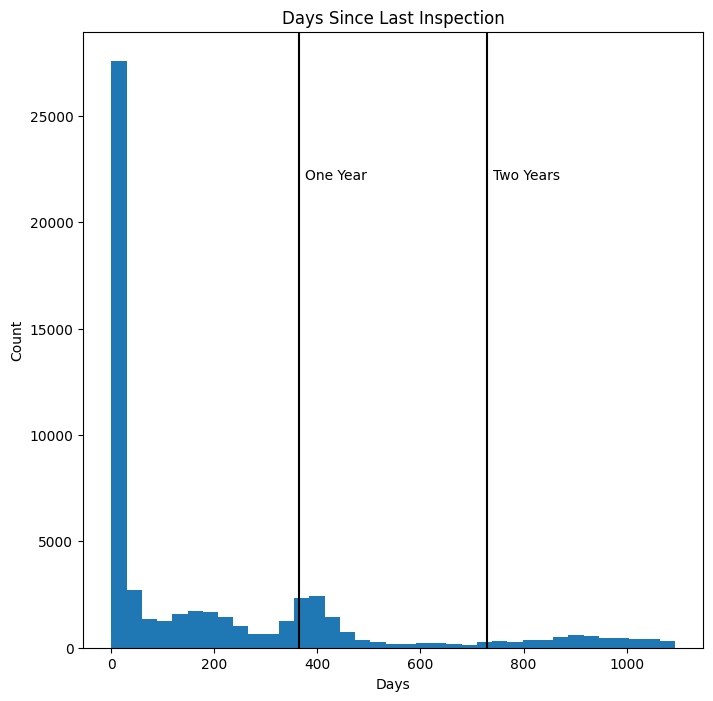

In [26]:
plt.figure(figsize=(8, 8))
plt.hist(nyc_restaurants["DAYS SINCE LAST INSPECTION"], bins = 37)
plt.xlabel("Days")
plt.ylabel("Count")
plt.title("Days Since Last Inspection")
plt.axvline(365, color = "black")
plt.text(375, 22000, "One Year")
plt.axvline(730, color = "black")
plt.text(740, 22000, "Two Years")
#plt.savefig("Results/last inspection.png")
plt.show()

In [27]:
#total_violations = nyc_restaurants.groupby("CAMIS")["VIOLATIONS PER INSPECTION"].aggregate("sum")
#total_critical_flags = nyc_restaurants.groupby("CAMIS")["CRITICAL FLAGS PER INSPECTION"].aggregate("sum")
#avg_score = nyc_restaurants.groupby("CAMIS")["SCORE"].aggregate("sum")/total_inspections

### Select Single Instance of Restaurant

In [28]:
nyc_restaurants = nyc_restaurants.groupby(["CAMIS"]).apply(lambda x: x.sample(1, random_state = SEED)).reset_index(drop = True)
nyc_restaurants["CAMIS"].value_counts()
#X_test = X_test.loc[X_test.groupby(["CAMIS", "INSPECTION DATE"])["VIOLATIONS PER INSPECTION"].idxmax()]

CAMIS
30075445    1
50090854    1
50090847    1
50090846    1
50090843    1
           ..
50006582    1
50006574    1
50006556    1
50006550    1
50136989    1
Name: count, Length: 23536, dtype: int64

In [29]:
nyc_restaurants["DBA"].value_counts()

DBA
DUNKIN                         375
STARBUCKS                      208
SUBWAY                         188
MCDONALD'S                     167
POPEYES                        108
                              ... 
FRUITTI YUMMI FROZEN YOGURT      1
LAND-O-FUN                       1
TOSHKENT RESTAURANT              1
CONDE NAST                       1
HOT SPOT GRILL & JERK            1
Name: count, Length: 18906, dtype: int64

In [30]:
# if number inspections > 3*number of years == high risk/many inspections
# does not account for restaurant with many inspections one year but improves overtime

years_array = np.array(years_in_data)
years_array = years_array * 3
max_inspections = years_array.tolist()

nyc_restaurants["TOTAL INSPECTIONS"] = total_inspections
nyc_restaurants["RISKY BUSINESS"] = "0"
nyc_restaurants.loc[nyc_restaurants["TOTAL INSPECTIONS"] > max_inspections, "RISKY BUSINESS"] = "1"
nyc_restaurants["MONTHS OPERATING"] = months_in_data


#years_array_test = np.array(years_in_data_test)
#years_array_test = years_array_test * 3
#max_inspections_test = years_array_test.tolist()

#X_test["TOTAL INSPECTIONS"] = total_inspections_test
#X_test["RISKY BUSINESS"] = "0"
#X_test.loc[X_test["TOTAL INSPECTIONS"] > max_inspections_test, "RISKY BUSINESS"] = "1"
#X_test["MONTHS OPERATING"] = months_in_data_test

# drop critical flag
# X_train = X_train.drop("CRITICAL FLAG", axis = 1)
# X_test = X_test.drop("CRITICAL FLAG", axis = 1)

### Train Test Split

In [31]:
X = nyc_restaurants.drop(["RISKY BUSINESS"], axis = 1)
y = nyc_restaurants["RISKY BUSINESS"]


seed(SEED)
ids = nyc_restaurants.CAMIS.tolist()
k = int(np.ceil(len(ids)*.7))
train_ids = sample(ids, k)

In [32]:
lst = []
[lst.append(np.where(X["CAMIS"] == x)[0].tolist()) for x in train_ids]
lst

# flatten list
def flatten_list(l):
    return [item for row in l for item in row]

train_indexes = flatten_list(lst)

X_train = X.iloc[train_indexes]
#131174/187609*100 
# ~70% of data (69.92%)

y_train = y.iloc[train_indexes]

X_test = X.drop(train_indexes, axis = 0)
y_test = y.drop(train_indexes, axis = 0)

X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

In [33]:
(len(X_train)/len(X))*100

70.00339904826649

In [34]:
y_train.value_counts()

RISKY BUSINESS
0    16187
1      289
Name: count, dtype: int64

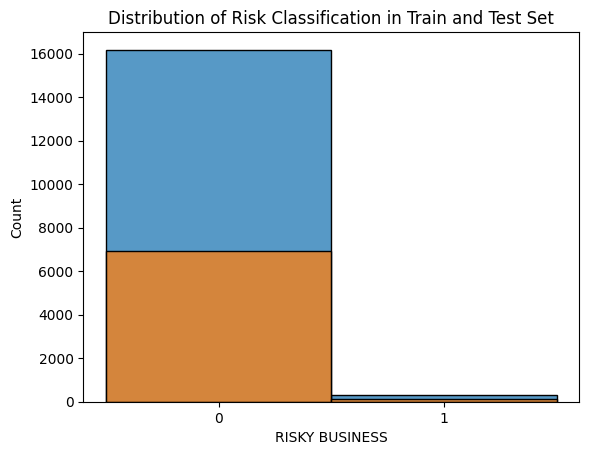

In [35]:
sns.histplot(y_train.sort_values(), label = "Train")
sns.histplot(y_test.sort_values(), label = "Test")
plt.title("Distribution of Risk Classification in Train and Test Set")
#plt.savefig("Results/train test risk.png")
plt.show()

### Update y_train and y_test indexes

In [36]:
#X_train = X_train.dropna()
#X_test = X_test.dropna()

train_index = X_train.index
test_index = X_test.index

y_train = y_train.iloc[train_index]
y_test = y_test.iloc[test_index]

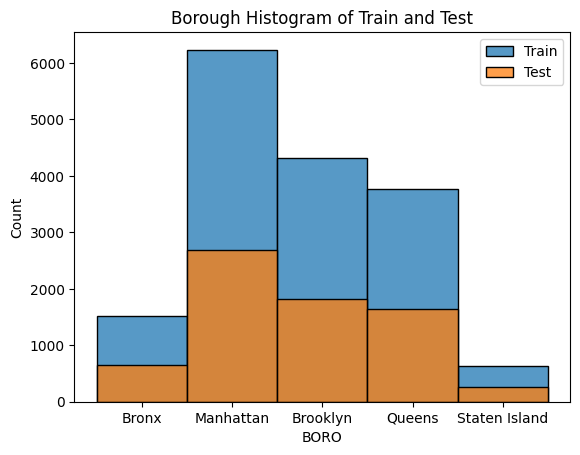

In [37]:
sns.histplot(X_train["BORO"], label = "Train")
sns.histplot(X_test["BORO"], label = "Test").set(title = "Borough Histogram of Train and Test")
plt.legend()
plt.show()

In [38]:
round(X_train[["BORO", "SCORE"]].groupby("BORO").mean(), 2)

,SCORE
BORO,
Bronx,16.57
Brooklyn,17.16
Manhattan,16.22
Queens,16.98
Staten Island,15.12


### Select Most Common Cuisines

In [39]:
#X_train["CUISINE DESCRIPTION"].value_counts().head(30)
#np.where(X_train["CUISINE DESCRIPTION"].value_counts() > 500)
top_cuisines = X_train["CUISINE DESCRIPTION"].value_counts().iloc[0:10]
top_cuisines

CUISINE DESCRIPTION
American                    3104
Chinese                     1388
Coffee/Tea                  1200
Pizza                       1036
Italian                      664
Mexican                      622
Japanese                     591
Latin American               554
Bakery Products/Desserts     552
Caribbean                    481
Name: count, dtype: int64

In [40]:
all_cuisines = X_train["CUISINE DESCRIPTION"].unique()
np.setdiff1d(X_train["CUISINE DESCRIPTION"].unique(), top_cuisines[0])
all_cuisines = all_cuisines[np.isin(all_cuisines, top_cuisines.axes) == False].tolist()
X_train["CUISINE DESCRIPTION"] = X_train["CUISINE DESCRIPTION"].replace(all_cuisines, "Other")

X_test["CUISINE DESCRIPTION"] = X_test["CUISINE DESCRIPTION"].replace(all_cuisines, "Other")

/var/folders/3r/2gdxtbds6szcszj9bg_tdb_h0000gn/T/ipykernel_92194/1656742108.py:2: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [41]:
#X_test["CUISINE DESCRIPTION"].value_counts()
other_cuisines = ["Iranian", "Basque"]
X_test["CUISINE DESCRIPTION"] = X_test["CUISINE DESCRIPTION"].replace(other_cuisines, "Other")

In [42]:
#X_train.loc[X_train["CAMIS"] == 30075445][["INSPECTION DATE", "CRITICAL FLAG", 
# "CRITICAL FLAGS PER INSPECTION", "VIOLATIONS PER INSPECTION"]]

In [43]:
#X_train["CAMIS"].value_counts()

In [44]:
X_train.ZIPCODE.value_counts()
# 213 unique
# drop zipcodes and use coordinates (inconsistent - some restaurants listed in multiple zipcodes)

ZIPCODE
10019.0    414
10003.0    381
10036.0    367
10001.0    327
10013.0    305
          ... 
11241.0      1
11371.0      1
10168.0      1
10171.0      1
11242.0      1
Name: count, Length: 209, dtype: int64

In [45]:
#X_test["INSPECTION TYPE"].value_counts()

In [46]:
# check phone

# [number[0:3] for number in X_train.PHONE]
# X_train.PHONE.value_counts()

# X_train.loc[X_train["PHONE"] == "9172843260"]
# some businesses share phone number (ie. food stands, chains (2126159700 for Starbucks))

## Finalize X_train and X_test

In [47]:
X_train = X_train.drop(["CAMIS", "DBA", "BUILDING", "STREET", "ZIPCODE", "PHONE", 
                        "ACTION", "VIOLATION CODE", "CRITICAL FLAG"], axis = 1)

X_test = X_test.drop(["CAMIS", "DBA", "BUILDING", "STREET", "ZIPCODE", "PHONE", 
                      "ACTION", "VIOLATION CODE", "CRITICAL FLAG"], axis = 1)

X_train

,BORO,CUISINE DESCRIPTION,INSPECTION DATE,VIOLATION DESCRIPTION,SCORE,INSPECTION TYPE,Latitude,Longitude,INSPECTION PURPOSE,GRADED,POST COVID,CRITICAL FLAGS PER INSPECTION,VIOLATIONS PER INSPECTION,DAYS SINCE LAST INSPECTION,YEAR,MONTH,DAY,TOTAL INSPECTIONS,MONTHS OPERATING
0,Bronx,Pizza,2020-03-05,Evidence of mice or live mice present in facil...,7.0,Cycle,40.845353,-73.865506,Initial,1,0,1,1,0,2020,03,05,2,28
1,Manhattan,American,2022-10-26,Accurate thermometer not provided or properly ...,10.0,Cycle,40.771553,-73.961387,Initial,1,1,1,2,0,2022,10,26,1,0
2,Brooklyn,American,2022-06-09,Live roaches present in facility's food and/or...,0.0,Cycle,40.618305,-73.991027,Initial,0,1,4,6,0,2022,06,09,3,9
3,Bronx,Latin American,2019-06-13,Food Protection Certificate not held by superv...,26.0,Cycle,40.869540,-73.827123,Initial,0,0,3,3,0,2019,06,13,3,35
4,Bronx,Other,2022-10-27,Non-food contact surface or equipment made of ...,10.0,Pre-permit,40.834032,-73.853141,Initial,1,1,1,2,0,2022,10,27,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16471,Manhattan,Other,2022-05-03,"Sanitized equipment or utensil, including in-u...",8.0,Cycle,40.706014,-74.011333,Initial,1,1,1,2,0,2022,05,03,2,12
16472,Brooklyn,Other,2022-12-05,"Food, supplies, and equipment not protected fr...",7.0,Pre-permit,40.716792,-73.962076,Initial,0,1,1,2,0,2022,12,05,1,0
16473,Queens,Caribbean,2020-02-22,Evidence of mice or live mice present in facil...,11.0,Pre-permit,40.685121,-73.830120,Initial,0,0,1,2,0,2020,02,22,2,30
16474,Manhattan,American,2020-01-06,Food not protected from potential source of co...,6.0,Cycle,40.754439,-73.987150,Initial,1,0,1,1,0,2020,01,06,3,31


In [48]:
# save as csv files

#X_train.to_csv(PATH + "X_train_restaurants.csv")
#X_test.to_csv(PATH + "X_test_restaurants.csv")
#y_train.to_csv(PATH + "y_train_restaurants.csv")
#y_test.to_csv(PATH + "y_test_restaurants.csv")